In [1]:
import os
from pathlib import Path
from functools import partial
from typing import Any, cast

import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.plotting import hot_cmap
from src.preprocessing import InferencePreprocessing

DATASET_DIR = Path(os.environ["MVTEC_DATASET_DIR"])
SAVED_MODEL = Path(os.environ["MVTEC_SAVED_MODEL"])
HISTORY_FILE = Path(os.environ["MVTEC_HISTORY_FILE"])

<Axes: xlabel='epoch'>

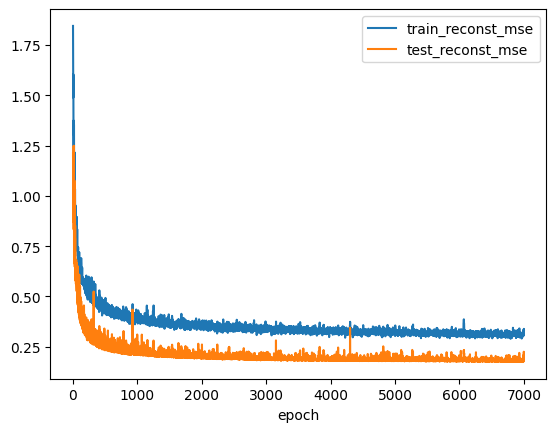

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 5].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: torch.Tensor) -> torch.Tensor:
    return torch.tensor(0) if label == 0 else torch.tensor(1)

create_ds = partial(
        MVTecAD,
        dataset_dir=DATASET_DIR,
        object=os.environ["MVTEC_OBJECT"],
        sample_transform=InferencePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
_ = model.eval()

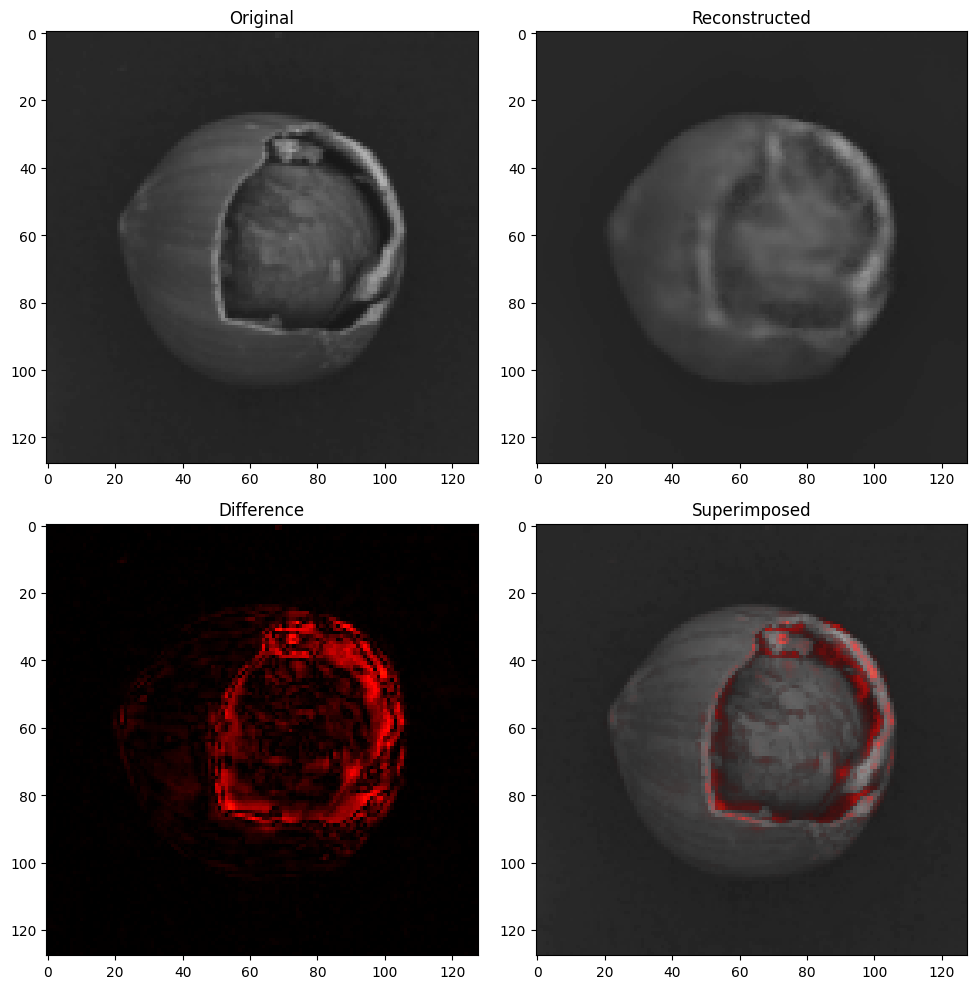

In [5]:
img_original, _ = cast(torch.Tensor, ds_test[42])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original))

img_diff = (img_original - img_reconstr).abs()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

def plot_image(ax, img: torch.Tensor, title: str, cmap: Any, alpha=1) -> None:
    ax.imshow(img.movedim(0, -1), cmap=cmap, vmin=0, vmax=1, alpha=alpha)
    ax.set_title(title)

plot_image(axs[0, 0], img_original, title="Original", cmap="gray")
plot_image(axs[0, 1], img_reconstr, title="Reconstructed", cmap="gray")
plot_image(axs[1, 0], img_diff, title="Difference", cmap=hot_cmap())
plot_image(axs[1, 1], img_original, title="", cmap="grey")
plot_image(axs[1, 1], img_diff, title="Superimposed", cmap=hot_cmap(use_alpha=True), alpha=0.7)


In [6]:
data: dict[str, Any] = {"set": [], "idx": [], "loss": [], "label": []}

def perform_inference(ds: MVTecAD, set_name: str) -> None:
    loss_fn = torch.nn.L1Loss()

    for idx, (original, label) in enumerate(ds):
        with torch.no_grad():
            reconstructed = model(original)
            loss = loss_fn(reconstructed, original)

            data["set"].append(set_name)
            data["idx"].append(idx)
            data["loss"].append(loss.item())
            data["label"].append(int(label))

perform_inference(ds_train, "train")
perform_inference(ds_test, "test")

df = pd.DataFrame.from_dict(data)

print(df[["set", "loss"]].groupby("set").describe())

        loss                                                              \
       count      mean       std       min       25%       50%       75%   
set                                                                        
test   110.0  0.009248  0.003323  0.005554  0.007278  0.008137  0.009459   
train  391.0  0.007184  0.000985  0.004940  0.006490  0.007014  0.007711   

                 
            max  
set              
test   0.024064  
train  0.012134  


In [7]:
decision_boundary = df[df["set"] == "train"]["loss"].quantile(0.95)

df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

df_test = df[df["set"] == "test"]

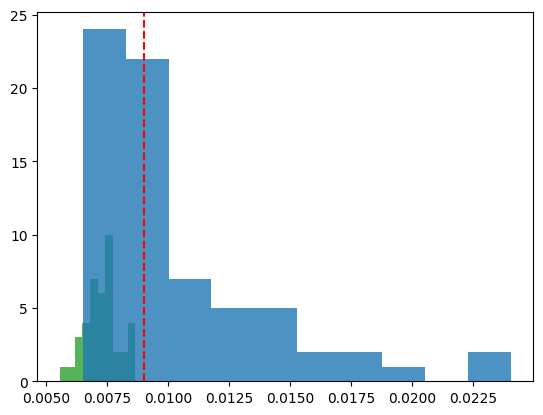

In [8]:
plt.hist(df_test[df_test["label"] == 0]["loss"], color="tab:green", alpha=0.8)
plt.hist(df_test[df_test["label"] == 1]["loss"], color="tab:blue", alpha=0.8)
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [9]:
accuracy = sum(df_test["label"] == df_test["prediction"]) / len(df_test)
accuracy

0.6909090909090909